In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_API_KEY"] = "47aa32aca06bea662b4b8c2246cefcb55bd15dab"
!wandb login

wandb: Currently logged in as: da24m012 (da24m012-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNClassifier(nn.Module):
    def __init__(self,
                 input_channels=3,  # RGB images
                 num_classes=10,
                 filter_sizes=(3, 3, 3, 3, 3),  # Kernel sizes for each conv layer
                 num_filters=(32, 64, 128, 256, 512),  # Filters per conv layer
                 conv_activation=F.relu,  # Activation after conv layers
                 dense_neurons=1024,  # Neurons in the dense layer
                 dense_activation=F.relu,  # Activation after dense layer
                 input_height=224,
                 input_width=224):

        super(CNNClassifier, self).__init__()

        self.conv_activation = conv_activation
        self.dense_activation = dense_activation

        self.conv_layers = nn.ModuleList()

        in_channels = input_channels
        current_height, current_width = input_height, input_width

        # Build convolutional layers
        for i in range(5):
            out_channels = num_filters[i]
            filter_size = filter_sizes[i]
            padding = filter_size // 2  # Same padding

            conv = nn.Conv2d(in_channels, out_channels, kernel_size=filter_size,
                             stride=1, padding=padding)
            self.conv_layers.append(conv)

            current_height //= 2
            current_width //= 2
            in_channels = out_channels

        dense_input_size = num_filters[-1] * current_height * current_width

        self.dense = nn.Linear(dense_input_size, dense_neurons)
        self.output = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        for conv in self.conv_layers:
            x = conv(x)
            x = self.conv_activation(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        x = self.dense_activation(self.dense(x))
        x = self.output(x)
        return x

In [ ]:
import os
import random
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from torch.nn import functional as F

# Reproducibility 
def set_seed(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Activation Functions 
activation_functions = {
    "relu": F.relu,
    "leaky_relu": F.leaky_relu,
    "gelu": F.gelu,
    "silu": F.silu,
    "mish": F.mish
}

# Dataset 
class iNaturalistDataset(Dataset):
    """Custom dataset to apply transformations."""
    def __init__(self, data_dir, transform=None):
        self.dataset = ImageFolder(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Stratified Split 
def create_stratified_split(dataset, val_size=0.2, seed=42):
    """Create a stratified train-validation split."""
    labels = [dataset.dataset.targets[i] for i in range(len(dataset))]
    indices = list(range(len(dataset)))
    train_idx, val_idx = train_test_split(
        indices, test_size=val_size, stratify=labels, random_state=seed
    )
    return train_idx, val_idx

# DataLoaders 
def get_dataloaders(config):
    """Create data loaders with optional augmentation."""
    # Base transform
    base_transform = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    # Data augmentation if enabled
    if config['data_augmentation']:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        ] + base_transform[1:])
    else:
        train_transform = transforms.Compose(base_transform)

    val_transform = transforms.Compose(base_transform)

    train_dataset = iNaturalistDataset('/kaggle/input/nature-12k/inaturalist_12K/train', transform=train_transform)
    train_idx, val_idx = create_stratified_split(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True)
    val_loader = DataLoader(iNaturalistDataset('/kaggle/input/nature-12k/inaturalist_12K/train', transform=val_transform), batch_size=config['batch_size'], sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True)
    test_loader = DataLoader(iNaturalistDataset('/kaggle/input/nature-12k/inaturalist_12K/val', transform=val_transform), batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader

# Model Creation 
def create_model(config, device):
    """Initialize and return the CNN model."""
    if config['filter_organization'] == 'same':
        filters = [int(config['base_filters'])] * 5
    elif config['filter_organization'] == 'doubling':
        filters = [int(config['base_filters'] * (2**i)) for i in range(5)]
    elif config['filter_organization'] == 'halving':
        filters = [int(config['base_filters'] / (2**i)) for i in range(5)]
    else:
        raise ValueError(f"Unknown filter_organization: {config['filter_organization']}")

    print("Filter configuration:", filters)

    model = CNNClassifier(
        input_channels=3,
        num_classes=10,
        filter_sizes=(3, 3, 3, 3, 3),
        num_filters=tuple(filters),
        conv_activation=activation_functions[config['activation']],
        dense_neurons=config['dense_neurons'],
        dense_activation=activation_functions[config['activation']],
        input_height=224,
        input_width=224
    ).to(device)

    if config['batch_norm']:
        bn_layers = nn.ModuleList([nn.BatchNorm2d(f).to(device) for f in filters])
        original_forward = model.forward

        def forward_with_bn(x):
            for i, conv in enumerate(model.conv_layers):
                x = conv(x)
                x = bn_layers[i](x)
                x = model.conv_activation(x)
                x = F.max_pool2d(x, 2, 2)
            x = x.view(x.size(0), -1)
            x = model.dense(x)
            x = model.dense_activation(x)
            if hasattr(model, 'dropout') and model.dropout:
                x = model.dropout(x)
            return model.output(x)

        model.forward = forward_with_bn
        model.bn_layers = bn_layers

    model.dropout = nn.Dropout(config['dropout']) if config['dropout'] > 0 else None
    return model

# Training Functions 
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader.sampler), correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(val_loader.sampler), correct / total

# Utilities 
def generate_run_name(config):
    """Create a descriptive run name for wandb."""
    return (
        f"bs{config.get('batch_size')}_lr{config.get('learning_rate'):.0e}_wd{config.get('weight_decay'):.0e}_"
        f"bf{config.get('base_filters')}_{config.get('filter_organization')}_{config.get('activation')}_"
        f"dn{config.get('dense_neurons')}_do{config.get('dropout')}_bn{int(config.get('batch_norm'))}_"
        f"aug{int(config.get('data_augmentation'))}"
    )

# Training Loop 
def train():
    print("Init Wandb...")
    run = wandb.init()
    print("Wandb init success.")

    config = wandb.config
    run.name = generate_run_name(config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_loader, val_loader, test_loader = get_dataloaders(config)
    model = create_model(config, device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_config = None

    for epoch in range(config.epochs):
        print("Epoch", epoch+1)
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        })

        print("Train Accuracy", train_acc)
        print("Val Accuracy", val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            best_config = dict(config)
            with open('best_config.json', 'w') as f:
                json.dump(best_config, f, indent=4)
            wandb.save('best_model.pth')
            wandb.save('best_config.json')

    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Sweep Config 
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-2},
        'weight_decay': {'distribution': 'log_uniform_values', 'min': 1e-6, 'max': 1e-3},
        'base_filters': {'values': [16, 32, 64]},
        
        'filter_organization': {'values': ['same', 'doubling', 'halving']},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'dense_neurons': {'values': [512, 1024, 2048]},
        'dropout': {'values': [0.0, 0.2, 0.3, 0.5]},
        'batch_norm': {'values': [True, False]},
        'data_augmentation': {'values': [True, False]},
        'epochs': {'value': 10}
    }
}

# Run Sweep 
def main():
    print("Success")
    sweep_id = wandb.sweep(sweep_config, project="A2")
    print("Running Sweep")
    wandb.agent(sweep_id, train, count=15)

In [4]:
main()
# 13.46

Success
Create sweep with ID: kt1c7sqy
Sweep URL: https://wandb.ai/da24m012-iit-madras/A2/sweeps/kt1c7sqy
Running Sweep


wandb: Agent Starting Run: llw39ukw with config:
wandb: 	activation: relu
wandb: 	base_filters: 16
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: halving
wandb: 	learning_rate: 0.00023942023381530575
wandb: 	weight_decay: 6.53978983815551e-05


Init Wandb...


wandb: Currently logged in as: da24m012 (da24m012-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Wandb init success.
Using device: cuda
Filter configuration: [16, 8, 4, 2, 1]
Epoch 1
Train Accuracy 0.09563695461932742
Val Accuracy 0.1
Epoch 2
Train Accuracy 0.09213651706463308
Val Accuracy 0.1
Epoch 3
Train Accuracy 0.0928866108263533
Val Accuracy 0.1
Epoch 4
Train Accuracy 0.09526190773846731
Val Accuracy 0.1
Epoch 5
Train Accuracy 0.10063757969746218
Val Accuracy 0.1
Epoch 6
Train Accuracy 0.09376172021502688
Val Accuracy 0.1
Epoch 7
Train Accuracy 0.09851231403925491
Val Accuracy 0.1
Epoch 8
Train Accuracy 0.09676209526190774
Val Accuracy 0.1
Epoch 9
Train Accuracy 0.09676209526190774
Val Accuracy 0.1
Epoch 10
Train Accuracy 0.09463682960370046
Val Accuracy 0.1


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█████▃▃▃▃▁
train_accuracy,▄▁▂▄█▂▆▅▅▃
train_loss,▇█▅▄▄▄▂▁▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▄▂▁▁▁▁
epoch,9
learning_rate,6e-05
train_accuracy,0.09464
train_loss,2.30323
val_accuracy,0.1


wandb: Agent Starting Run: pwdxwnh2 with config:
wandb: 	activation: relu
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0011373745998766926
wandb: 	weight_decay: 0.0006734120591739989


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [64, 64, 64, 64, 64]
Epoch 1
Train Accuracy 0.15226903362920366
Val Accuracy 0.2095
Epoch 2
Train Accuracy 0.18802350293786724
Val Accuracy 0.233
Epoch 3
Train Accuracy 0.18377297162145267
Val Accuracy 0.2325
Epoch 4
Train Accuracy 0.2044005500687586
Val Accuracy 0.248
Epoch 5
Train Accuracy 0.2149018627328416
Val Accuracy 0.25
Epoch 6
Train Accuracy 0.22477809726215778
Val Accuracy 0.264
Epoch 7
Train Accuracy 0.23365420677584697
Val Accuracy 0.2645
Epoch 8
Train Accuracy 0.2331541442680335
Val Accuracy 0.274
Epoch 9
Train Accuracy 0.23940492561570195
Val Accuracy 0.2945
Epoch 10
Train Accuracy 0.24678084760595073
Val Accuracy 0.2945


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▃▅▆▆▇▇▇█
train_loss,█▄▄▃▃▂▂▂▁▁
val_accuracy,▁▃▃▄▄▅▆▆██
val_loss,█▆▇▅▅▄▃▃▂▁
epoch,9
learning_rate,0.00114
train_accuracy,0.24678
train_loss,2.08284
val_accuracy,0.2945


wandb: Agent Starting Run: 6o8gercd with config:
wandb: 	activation: relu
wandb: 	base_filters: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: halving
wandb: 	learning_rate: 0.00014322315756839994
wandb: 	weight_decay: 4.201448756024912e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [32, 16, 8, 4, 2]
Epoch 1
Train Accuracy 0.09526190773846731
Val Accuracy 0.0985
Epoch 2
Train Accuracy 0.13089136142017752
Val Accuracy 0.1645
Epoch 3
Train Accuracy 0.15914489311163896
Val Accuracy 0.179
Epoch 4
Train Accuracy 0.1593949243655457
Val Accuracy 0.1785
Epoch 5
Train Accuracy 0.17289661207650955
Val Accuracy 0.195
Epoch 6
Train Accuracy 0.17889736217027127
Val Accuracy 0.201
Epoch 7
Train Accuracy 0.18439804975621954
Val Accuracy 0.227
Epoch 8
Train Accuracy 0.19289911238904864
Val Accuracy 0.228
Epoch 9
Train Accuracy 0.19964995624453058
Val Accuracy 0.222
Epoch 10
Train Accuracy 0.19677459682460308
Val Accuracy 0.231


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▅▆▇▇███
train_loss,█▇▄▃▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▆████
val_loss,█▅▅▄▄▃▂▁▂▁
epoch,9
learning_rate,0.00014
train_accuracy,0.19677
train_loss,2.18065
val_accuracy,0.231


wandb: Agent Starting Run: olsy7a5s with config:
wandb: 	activation: relu
wandb: 	base_filters: 16
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 0.00023125020038262703
wandb: 	weight_decay: 0.00015864483887861191


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 32, 64, 128, 256]
Epoch 1
Train Accuracy 0.2389048631078885
Val Accuracy 0.2725
Epoch 2
Train Accuracy 0.2921615201900237
Val Accuracy 0.331
Epoch 3
Train Accuracy 0.3221652706588324
Val Accuracy 0.3475
Epoch 4
Train Accuracy 0.34329291161395176
Val Accuracy 0.366
Epoch 5
Train Accuracy 0.36754594324290535
Val Accuracy 0.3585
Epoch 6
Train Accuracy 0.3857982247780973
Val Accuracy 0.366
Epoch 7
Train Accuracy 0.4131766470808851
Val Accuracy 0.371
Epoch 8
Train Accuracy 0.4358044755594449
Val Accuracy 0.393
Epoch 9
Train Accuracy 0.45693211651456433
Val Accuracy 0.4065
Epoch 10
Train Accuracy 0.4704338042255282
Val Accuracy 0.4005


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▄▅▆▅▆▆▇██
val_loss,█▆▅▄▄▄▅▂▁▃
epoch,9
learning_rate,0.00023
train_accuracy,0.47043
train_loss,1.48449
val_accuracy,0.4005


wandb: Agent Starting Run: 3096mt86 with config:
wandb: 	activation: silu
wandb: 	base_filters: 16
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: halving
wandb: 	learning_rate: 5.5566791588353815e-05
wandb: 	weight_decay: 3.190565087831164e-05


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 8, 4, 2, 1]
Epoch 1
Train Accuracy 0.10001250156269534
Val Accuracy 0.1
Epoch 2
Train Accuracy 0.09388673584198025
Val Accuracy 0.1205
Epoch 3
Train Accuracy 0.09638704838104763
Val Accuracy 0.1
Epoch 4
Train Accuracy 0.10663832979122391
Val Accuracy 0.104
Epoch 5
Train Accuracy 0.1030128766095762
Val Accuracy 0.1095
Epoch 6
Train Accuracy 0.1131391423927991
Val Accuracy 0.147
Epoch 7
Train Accuracy 0.13889236154519316
Val Accuracy 0.161
Epoch 8
Train Accuracy 0.1483935491936492
Val Accuracy 0.167
Epoch 9
Train Accuracy 0.16164520565070634
Val Accuracy 0.19
Epoch 10
Train Accuracy 0.16202025253156643
Val Accuracy 0.1835


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▂▁▁▂▂▃▆▇██
train_loss,█████▅▄▂▂▁
val_accuracy,▁▃▁▁▂▅▆▆█▇
val_loss,████▇▅▃▂▂▁
epoch,9
learning_rate,6e-05
train_accuracy,0.16202
train_loss,2.25092
val_accuracy,0.1835


wandb: Agent Starting Run: axnl8cky with config:
wandb: 	activation: relu
wandb: 	base_filters: 16
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: halving
wandb: 	learning_rate: 0.003979443345553343
wandb: 	weight_decay: 0.0001431525150973778


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 8, 4, 2, 1]
Epoch 1
Train Accuracy 0.14564320540067507
Val Accuracy 0.1595
Epoch 2
Train Accuracy 0.18839854981872733
Val Accuracy 0.1725
Epoch 3
Train Accuracy 0.20365045630703837
Val Accuracy 0.194
Epoch 4
Train Accuracy 0.21152644080510064
Val Accuracy 0.1945
Epoch 5
Train Accuracy 0.23040380047505937
Val Accuracy 0.19
Epoch 6
Train Accuracy 0.24215526940867607
Val Accuracy 0.207
Epoch 7
Train Accuracy 0.2611576447055882
Val Accuracy 0.215
Epoch 8
Train Accuracy 0.2791598949868734
Val Accuracy 0.207
Epoch 9
Train Accuracy 0.2960370046255782
Val Accuracy 0.212
Epoch 10
Train Accuracy 0.3195399424928116
Val Accuracy 0.1985


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▆▆▇█
train_loss,█▇▆▆▅▅▄▃▂▁
val_accuracy,▁▃▅▅▅▇█▇█▆
val_loss,▄▃▂▂▂▂▁▂▄█
epoch,9
learning_rate,0.00398
train_accuracy,0.31954
train_loss,1.91034
val_accuracy,0.1985


wandb: Agent Starting Run: nb7iy8ly with config:
wandb: 	activation: silu
wandb: 	base_filters: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 0.0001558686897004135
wandb: 	weight_decay: 3.490517274265702e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [32, 64, 128, 256, 512]
Epoch 1
Train Accuracy 0.20452556569571195
Val Accuracy 0.269
Epoch 2
Train Accuracy 0.24765595699462434
Val Accuracy 0.2855
Epoch 3
Train Accuracy 0.2629078634829354
Val Accuracy 0.3015
Epoch 4
Train Accuracy 0.2794099262407801
Val Accuracy 0.3105
Epoch 5
Train Accuracy 0.28366045755719466
Val Accuracy 0.341
Epoch 6
Train Accuracy 0.2856607075884486
Val Accuracy 0.3245
Epoch 7
Train Accuracy 0.3077884735591949
Val Accuracy 0.3425
Epoch 8
Train Accuracy 0.30703837979747467
Val Accuracy 0.356
Epoch 9
Train Accuracy 0.3182897862232779
Val Accuracy 0.376
Epoch 10
Train Accuracy 0.31478934866858355
Val Accuracy 0.3835


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▂▃▄▅▄▅▆██
val_loss,█▇▆▅▄▄▃▂▁▁
epoch,9
learning_rate,0.00016
train_accuracy,0.31479
train_loss,1.90515
val_accuracy,0.3835


wandb: Agent Starting Run: 9scbppya with config:
wandb: 	activation: mish
wandb: 	base_filters: 16
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	learning_rate: 2.6336821598124044e-05
wandb: 	weight_decay: 0.00012985563257810089


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 16, 16, 16, 16]
Epoch 1
Train Accuracy 0.16277034629328666
Val Accuracy 0.244
Epoch 2
Train Accuracy 0.20252531566445806
Val Accuracy 0.27
Epoch 3
Train Accuracy 0.22640330041255158
Val Accuracy 0.2865
Epoch 4
Train Accuracy 0.22527815976997126
Val Accuracy 0.293
Epoch 5
Train Accuracy 0.24303037879734968
Val Accuracy 0.287
Epoch 6
Train Accuracy 0.2440305038129766
Val Accuracy 0.297
Epoch 7
Train Accuracy 0.2510313789223653
Val Accuracy 0.3
Epoch 8
Train Accuracy 0.2526565820727591
Val Accuracy 0.3
Epoch 9
Train Accuracy 0.25453181647705964
Val Accuracy 0.29
Epoch 10
Train Accuracy 0.2725340667583448
Val Accuracy 0.305


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▇▇▇█
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▄▆▇▆▇▇▇▆█
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,9
learning_rate,3e-05
train_accuracy,0.27253
train_loss,2.0501
val_accuracy,0.305


wandb: Agent Starting Run: 24c45djh with config:
wandb: 	activation: relu
wandb: 	base_filters: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 1024
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 2.832973303599575e-05
wandb: 	weight_decay: 4.912994720113533e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [32, 64, 128, 256, 512]
Epoch 1
Train Accuracy 0.1731466433304163
Val Accuracy 0.2395
Epoch 2
Train Accuracy 0.24840605075634453
Val Accuracy 0.2645
Epoch 3
Train Accuracy 0.2886610826353294
Val Accuracy 0.3145
Epoch 4
Train Accuracy 0.31378922365295664
Val Accuracy 0.317
Epoch 5
Train Accuracy 0.33066633329166145
Val Accuracy 0.33
Epoch 6
Train Accuracy 0.3330416302037755
Val Accuracy 0.3395
Epoch 7
Train Accuracy 0.34729341167645955
Val Accuracy 0.336
Epoch 8
Train Accuracy 0.35429428678584823
Val Accuracy 0.3385
Epoch 9
Train Accuracy 0.3584198024753094
Val Accuracy 0.3375
Epoch 10
Train Accuracy 0.37129641205150643
Val Accuracy 0.3465


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▃▆▆▇█▇▇▇█
val_loss,█▆▄▃▃▂▂▂▂▁
epoch,9
learning_rate,3e-05
train_accuracy,0.3713
train_loss,1.79947
val_accuracy,0.3465


wandb: Agent Starting Run: 8ge8vno8 with config:
wandb: 	activation: gelu
wandb: 	base_filters: 16
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0004382759187837912
wandb: 	weight_decay: 3.420308708465109e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 16, 16, 16, 16]
Epoch 1
Train Accuracy 0.14401800225028127
Val Accuracy 0.184
Epoch 2
Train Accuracy 0.18727340917614702
Val Accuracy 0.2155
Epoch 3
Train Accuracy 0.19702462807850982
Val Accuracy 0.2415
Epoch 4
Train Accuracy 0.2149018627328416
Val Accuracy 0.261
Epoch 5
Train Accuracy 0.22402800350043756
Val Accuracy 0.277
Epoch 6
Train Accuracy 0.2331541442680335
Val Accuracy 0.281
Epoch 7
Train Accuracy 0.23452931616452055
Val Accuracy 0.2845
Epoch 8
Train Accuracy 0.24390548818602326
Val Accuracy 0.288
Epoch 9
Train Accuracy 0.2550318789848731
Val Accuracy 0.299
Epoch 10
Train Accuracy 0.2599074884360545
Val Accuracy 0.305


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▃▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▄▃▃▃▂▂▁
epoch,9
learning_rate,0.00044
train_accuracy,0.25991
train_loss,2.05623
val_accuracy,0.305


wandb: Agent Starting Run: aozm3urt with config:
wandb: 	activation: mish
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 0.00023752411179566265
wandb: 	weight_decay: 1.0045968733510016e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [64, 128, 256, 512, 1024]
Epoch 1
Train Accuracy 0.19877484685585697
Val Accuracy 0.2795
Epoch 2
Train Accuracy 0.2822852856607076
Val Accuracy 0.305
Epoch 3
Train Accuracy 0.31078884860607575
Val Accuracy 0.304
Epoch 4
Train Accuracy 0.3355419427428429
Val Accuracy 0.3255
Epoch 5
Train Accuracy 0.3451681460182523
Val Accuracy 0.337
Epoch 6
Train Accuracy 0.3762970371296412
Val Accuracy 0.3455
Epoch 7
Train Accuracy 0.37329666208276036
Val Accuracy 0.379
Epoch 8
Train Accuracy 0.4054256782097762
Val Accuracy 0.3735
Epoch 9
Train Accuracy 0.4284285535691961
Val Accuracy 0.3635
Epoch 10
Train Accuracy 0.4489311163895487
Val Accuracy 0.375


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▃▄▅▆██▇█
val_loss,█▆▆▄▃▄▁▁▁▁
epoch,9
learning_rate,0.00024
train_accuracy,0.44893
train_loss,1.56992
val_accuracy,0.375


wandb: Agent Starting Run: v3qkm8kl with config:
wandb: 	activation: mish
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 0.001805438717000175
wandb: 	weight_decay: 4.857230558162812e-06


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [64, 128, 256, 512, 1024]
Epoch 1
Train Accuracy 0.131391423927991
Val Accuracy 0.158
Epoch 2
Train Accuracy 0.15351918989873733
Val Accuracy 0.1795
Epoch 3
Train Accuracy 0.16189523690461308
Val Accuracy 0.1905
Epoch 4
Train Accuracy 0.16577072134016752
Val Accuracy 0.175
Epoch 5
Train Accuracy 0.1658957369671209
Val Accuracy 0.175
Epoch 6
Train Accuracy 0.16527065883235403
Val Accuracy 0.176
Epoch 7
Train Accuracy 0.16127015876984624
Val Accuracy 0.179
Epoch 8
Train Accuracy 0.16839604950618828
Val Accuracy 0.2115
Epoch 9
Train Accuracy 0.17514689336167022
Val Accuracy 0.206
Epoch 10
Train Accuracy 0.18502312789098638
Val Accuracy 0.21


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,██████▁▁▁▁
train_accuracy,▁▄▅▅▆▅▅▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▃▃▃▄█▇█
val_loss,█▆▃▄█▄▆▁▁▁
epoch,9
learning_rate,0.0009
train_accuracy,0.18502
train_loss,2.19988
val_accuracy,0.21


wandb: Agent Starting Run: 6ychtg50 with config:
wandb: 	activation: relu
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0010797126516440892
wandb: 	weight_decay: 1.693597771883434e-05


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [64, 64, 64, 64, 64]
Epoch 1
Train Accuracy 0.16402050256282036
Val Accuracy 0.2125
Epoch 2
Train Accuracy 0.19352419052381548
Val Accuracy 0.228
Epoch 3
Train Accuracy 0.21627703462932868
Val Accuracy 0.252
Epoch 4
Train Accuracy 0.22727840980122516
Val Accuracy 0.2825
Epoch 5
Train Accuracy 0.24515564445555693
Val Accuracy 0.287
Epoch 6
Train Accuracy 0.2461557694711839
Val Accuracy 0.289
Epoch 7
Train Accuracy 0.2497812226528316
Val Accuracy 0.271
Epoch 8
Train Accuracy 0.2586573321665208
Val Accuracy 0.288
Epoch 9
Train Accuracy 0.27065883235404425
Val Accuracy 0.2755
Epoch 10
Train Accuracy 0.2752844105513189
Val Accuracy 0.309


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▆▆▆▇██
train_loss,█▄▄▃▃▂▂▂▂▁
val_accuracy,▁▂▄▆▆▇▅▆▆█
val_loss,█▆▅▃▂▃▃▂▃▁
epoch,9
learning_rate,0.00108
train_accuracy,0.27528
train_loss,2.0173
val_accuracy,0.309


wandb: Agent Starting Run: frzcptsw with config:
wandb: 	activation: gelu
wandb: 	base_filters: 16
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: doubling
wandb: 	learning_rate: 6.487440825582764e-05
wandb: 	weight_decay: 0.00010074411916891854


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [16, 32, 64, 128, 256]
Epoch 1
Train Accuracy 0.1525190648831104
Val Accuracy 0.2065
Epoch 2
Train Accuracy 0.20227528441055131
Val Accuracy 0.249
Epoch 3
Train Accuracy 0.2246530816352044
Val Accuracy 0.2865
Epoch 4
Train Accuracy 0.23527940992624077
Val Accuracy 0.279
Epoch 5
Train Accuracy 0.2531566445805726
Val Accuracy 0.27
Epoch 6
Train Accuracy 0.2599074884360545
Val Accuracy 0.296
Epoch 7
Train Accuracy 0.2664083010376297
Val Accuracy 0.3005
Epoch 8
Train Accuracy 0.26703337917239656
Val Accuracy 0.2945
Epoch 9
Train Accuracy 0.2745343167895987
Val Accuracy 0.299
Epoch 10
Train Accuracy 0.28041005125640706
Val Accuracy 0.3185


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▆▆▅▇▇▆▇█
val_loss,█▇▄▄▃▂▁▁▁▁
epoch,9
learning_rate,6e-05
train_accuracy,0.28041
train_loss,2.02885
val_accuracy,0.3185


wandb: Agent Starting Run: oc32gpt1 with config:
wandb: 	activation: silu
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 2048
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: halving
wandb: 	learning_rate: 0.0003461930962515432
wandb: 	weight_decay: 1.3593946974650642e-05


Init Wandb...


Wandb init success.
Using device: cuda
Filter configuration: [64, 32, 16, 8, 4]
Epoch 1
Train Accuracy 0.18339792474059258
Val Accuracy 0.231
Epoch 2
Train Accuracy 0.2275284410551319
Val Accuracy 0.242
Epoch 3
Train Accuracy 0.24003000375046882
Val Accuracy 0.259
Epoch 4
Train Accuracy 0.25753219152394047
Val Accuracy 0.2925
Epoch 5
Train Accuracy 0.2550318789848731
Val Accuracy 0.279
Epoch 6
Train Accuracy 0.2655331916489561
Val Accuracy 0.304
Epoch 7
Train Accuracy 0.26815851981497685
Val Accuracy 0.291
Epoch 8
Train Accuracy 0.2755344418052256
Val Accuracy 0.2885
Epoch 9
Train Accuracy 0.27790973871733965
Val Accuracy 0.3175
Epoch 10
Train Accuracy 0.2794099262407801
Val Accuracy 0.328


/tmp/ipykernel_7101/2885304198.py:354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▃▅▄▆▅▅▇█
val_loss,██▆▄▄▃▄▂▂▁
epoch,9
learning_rate,0.00035
train_accuracy,0.27941
train_loss,2.00523
val_accuracy,0.328


In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Define supported activation functions
activation_functions = {
    "relu": F.relu,
    "leaky_relu": F.leaky_relu,
    "gelu": F.gelu,
    "silu": F.silu,
    "mish": F.mish
}

def load_best_model(model_path, config, device):
    """Load model architecture and weights based on sweep configuration"""
    
    # Create model using stored config
    model = create_model(config, device)

    # Move model to device (CPU/GPU)
    model = model.to(device)
    
    # Apply dropout if defined
    if config['dropout'] > 0:
        model.dropout = nn.Dropout(config['dropout'])
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode
    
    return model

def get_test_dataloader(batch_size=32):
    """Prepare test DataLoader with standard transforms"""
    
    # Define input preprocessing
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load test/validation dataset
    test_dataset = ImageFolder('/kaggle/input/nature-12k/inaturalist_12K/val', 
                               transform=test_transform)
    
    # Wrap dataset in DataLoader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    return test_loader, test_dataset

def evaluate_model(model, test_loader, device):
    """Run model inference and compute accuracy on test set"""
    
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Run forward pass
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Update stats
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Collect predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate overall accuracy
    test_acc = 100 * correct / total
    
    return test_acc, all_predictions, all_labels

def create_visualization_grid(test_dataset, predictions, true_labels, class_names, num_samples=30):
    """Visualize model predictions on a grid of test samples"""
    
    dataset_size = len(test_dataset)

    # Identify correctly and incorrectly predicted samples
    correct_indices = [i for i in range(dataset_size) 
                       if i < len(predictions) and predictions[i] == true_labels[i]]
    incorrect_indices = [i for i in range(dataset_size) 
                         if i < len(predictions) and predictions[i] != true_labels[i]]
    
    # Sample from both correct and incorrect predictions
    num_correct = min(20, len(correct_indices))
    num_incorrect = min(10, len(incorrect_indices))
    selected_correct = random.sample(correct_indices, num_correct)
    selected_incorrect = random.sample(incorrect_indices, num_incorrect)
    
    # Combine and shuffle selected samples
    selected_indices = selected_correct + selected_incorrect
    random.shuffle(selected_indices)
    selected_indices = selected_indices[:num_samples]
    
    # Create visualization grid
    fig = plt.figure(figsize=(15, 18))
    fig.suptitle("Model Predictions on Test Data", fontsize=20)

    # Color schemes
    correct_color = '#e6f7e6'   # Light green
    incorrect_color = '#ffebeb' # Light red
    
    rows, cols = 10, 3

    for i, idx in enumerate(selected_indices):
        img, label = test_dataset[idx]
        img = img.permute(1, 2, 0).cpu().numpy()
        
        # Undo normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        pred = predictions[idx] if idx < len(predictions) else -1
        is_correct = pred == label
        bg_color = correct_color if is_correct else incorrect_color
        
        # Add subplot for current image
        ax = plt.subplot(rows, cols, i + 1)
        ax.set_facecolor(bg_color)
        plt.imshow(img)
        
        # Annotate prediction and ground truth
        title = f"Pred: {class_names[pred]}\nTrue: {class_names[label]}"
        plt.title(title, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig('test_predictions_grid.png', bbox_inches='tight', dpi=200)
    
    return fig


In [17]:
def test_model():
    print("Init Wandb...")
    run = wandb.init()
    print("Wandb init success.")
    
    ENTITY = "da24m012-iit-madras"      # your wandb username or team
    PROJECT = "A2"
    SWEEP_ID = "kt1c7sqy"       # just the ID, not the full path
    
    api = wandb.Api()
    
    # Get all runs in the project
    all_runs = api.runs(f"{ENTITY}/{PROJECT}")
    
    # Filter runs that belong to the desired sweep
    sweep_runs = [run for run in all_runs if run.sweep and run.sweep.id == SWEEP_ID]
    best_run = max(sweep_runs, key=lambda run: run.summary.get("val_accuracy", 0.0))
    
    # Show details
    print(f"Best run ID: {best_run.id}")
    print(f"Name: {best_run.name}")
    print(f"Best Val Accuracy: {best_run.summary['val_accuracy']}")
    print("Config:", dict(best_run.config))
    config = dict(best_run.config)
    best_run.file("best_model.pth").download(replace=True)
    model_path = "/kaggle/working/best_model.pth"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Config", config.get("batch_size"))
    run.name = generate_run_name(config)
    print("Loading best model...")
    model = load_best_model(model_path, config, device)
    
    print("Preparing test data...")
    test_loader, test_dataset = get_test_dataloader(batch_size=config.get("batch_size"))
    
    # Evaluate model on test data
    print("Evaluating model on test data...")
    test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Get class names from dataset
    class_names = test_dataset.classes
    print("Creating visualization grid...")
    fig = create_visualization_grid(test_dataset, predictions, true_labels, class_names)
    
    print("Done! Check test_predictions_grid.png for the visualization.")

Init Wandb...


Wandb init success.
Best run ID: olsy7a5s
Name: bs32_lr2e-04_wd2e-04_bf16_doubling_relu_dn512_do0.3_bn1_aug0
Best Val Accuracy: 0.4005
Config: {'epochs': 10, 'dropout': 0.3, 'activation': 'relu', 'batch_norm': True, 'batch_size': 32, 'base_filters': 16, 'weight_decay': 0.00015864483887861191, 'dense_neurons': 512, 'learning_rate': 0.00023125020038262703, 'data_augmentation': False, 'filter_organization': 'doubling'}
Using device: cuda
Config 32
Loading best model...
Filter configuration: [16, 32, 64, 128, 256]
Preparing test data...
Evaluating model on test data...


/tmp/ipykernel_7101/123438359.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy: 40.95%
Creating visualization grid...
Done! Check test_predictions_grid.png for the visualization.


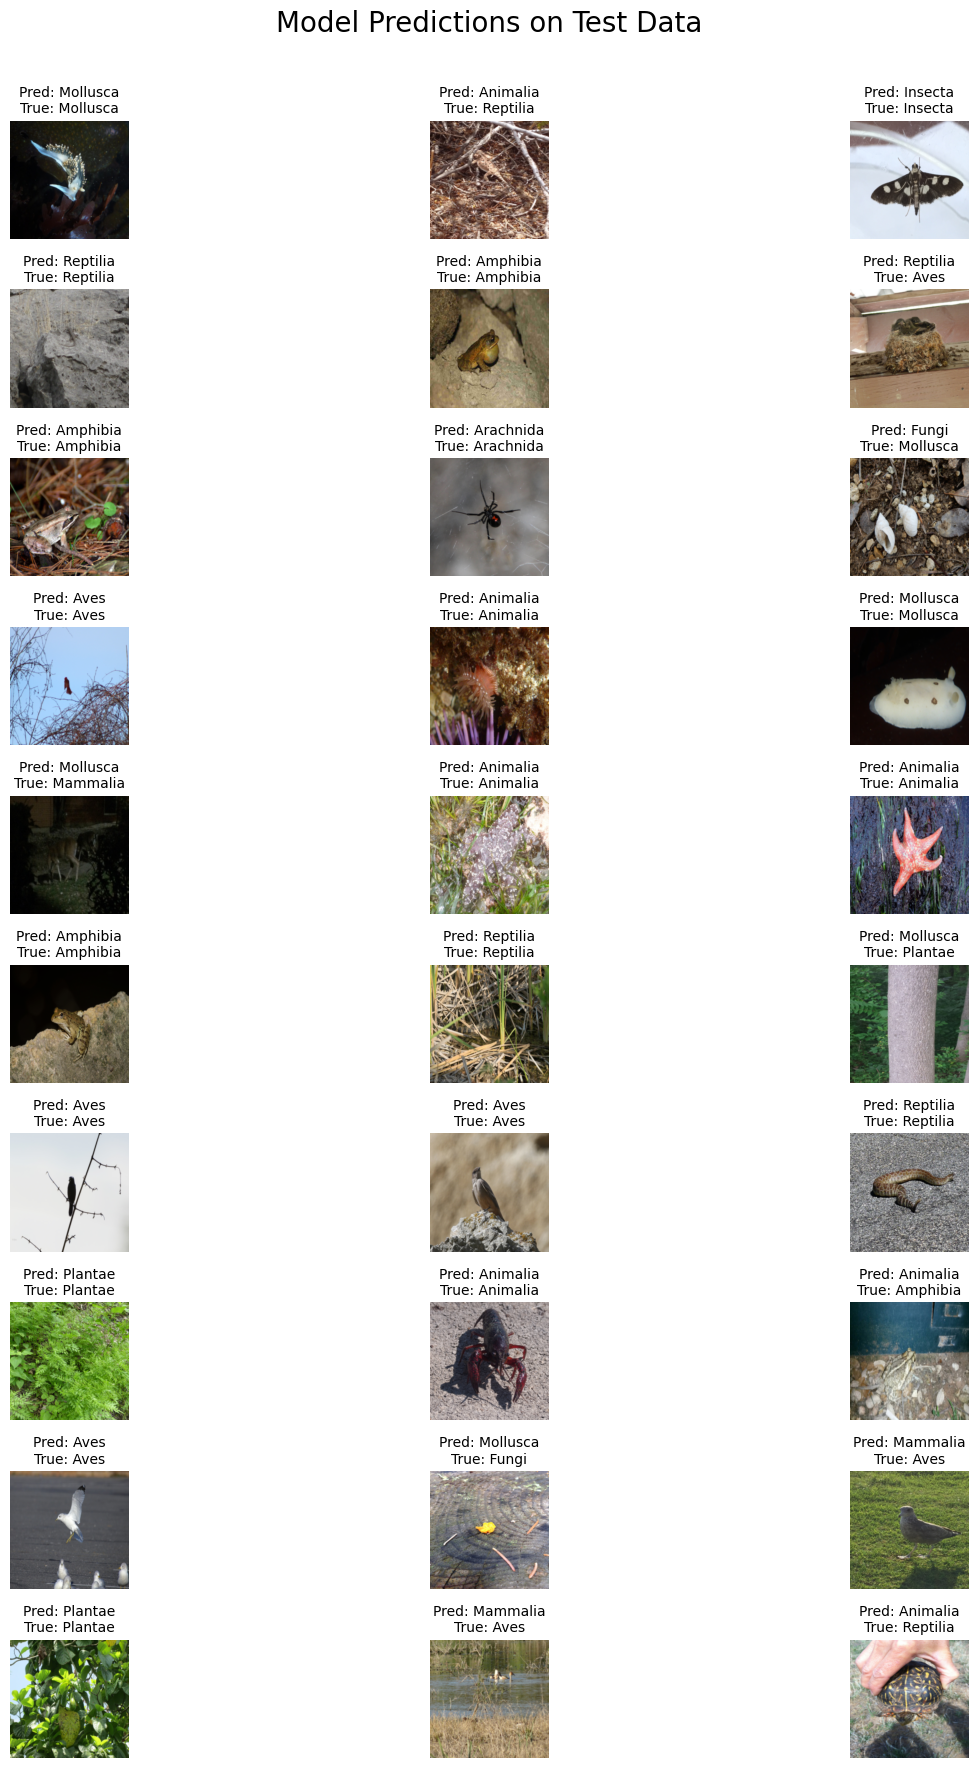

In [18]:

test_model()

In [ ]:
test_model()